In [1]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install gym==0.26.2
!pip install pybullet pybullet_envs
!pip install stable-baselines3[extra]
!pip install gymnasium
!pip install sentence-transformers
!pip install huggingface-hub
!pip install huggingface_hub[hf_xet]


ERROR: Could not find a version that satisfies the requirement pybullet_envs (from versions: none)
ERROR: No matching distribution found for pybullet_envs


In [2]:
import os
import glob
import time
from datetime import datetime
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

In [3]:
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print(str(torch.cuda.get_device_name(device)) + "is selected")
else:
    print("CPU is selected")

CPU is selected


In [6]:
df_incident.shape

(269361, 143)

In [ ]:
import pandas as pd
df_incident = pd.read_csv('data\merged_tickets.csv', encoding='latin1')
display(df_incident.head())

In [7]:
missing = df_incident.isnull().sum()
missing_cols = missing[missing > 0].sort_values(ascending=False)
print(missing_cols)

skills                  269361
u_current_work_notes    269361
u_helpnow_serial        269361
u_current_comments      269361
u_date_opened           269360
                         ...  
assignment_group           302
state                      302
opened_at                  301
child_incidents            299
sys_updated_on             297
Length: 141, dtype: int64


In [8]:
df_incident = df_incident.dropna(axis=1, thresh=len(df_incident)*0.2)

In [12]:
df_incident_cleaned = pd.read_csv('incident_cleaned.csv', encoding='latin1')
display(df_incident_cleaned.head())

C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22920\625651612.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_incident_cleaned = pd.read_csv('incident_cleaned.csv', encoding='latin1')


,location,short_description,category,subcategory,state,assignment_group,sys_updated_on,opened_at,business_duration,impact,incident_state,priority,resolved_at,urgency,short_desc_embedding
0,Ottawa - Kent St,"Hello, I'm missing out on some firm-wide email...",Infrastructure,Email Services,In Progress,IT Cloud Operations,2025-07-15 12:59:29 PM,2025-03-26 02:51:37 PM,0,3 - 10% or Less Users,In Progress,P3 - Normal,NaN,1 - High,"[0.03732522204518318, 0.01721048355102539, -0...."
1,Toronto - Wellington St,Privileged Role Assignment - Dynamics 365 Admi...,Software,Other,In Progress,IT Cloud Operations,2025-07-29 05:43:11 PM,2025-07-24 03:23:16 PM,0,3 - 10% or Less Users,In Progress,P4 - Low,NaN,3 - Low,"[0.03565394878387451, -0.001367107150144875, -..."
2,National,[Build failed] Maintenance (Nightly) - PDS-Ops...,Enterprise Business Applications,PDSHub,In Progress,IT Cloud Operations,2025-08-27 08:54:44 AM,2025-08-27 12:36:26 AM,0,3 - 10% or Less Users,In Progress,P4 - Low,NaN,3 - Low,"[-0.01677246205508709, -0.0011157342232763767,..."
3,Sudbury - Westmount Ave,Please update Fredericton mailing address and ...,Web Application,DebtSolutions.bdo.ca,In Progress,IT Cloud Operations,2025-08-27 01:02:36 PM,2025-08-27 12:58:15 PM,0,3 - 10% or Less Users,In Progress,P3 - Normal,NaN,1 - High,"[0.03588441386818886, 0.05134563148021698, -0...."
4,Toronto - Wellington St,Disable SMS MFA Enrollment for New Users,Security,Other,In Progress,IT Cloud Operations,2025-06-16 12:00:53 PM,2025-06-16 11:50:25 AM,0,3 - 10% or Less Users,In Progress,P4 - Low,NaN,3 - Low,"[0.006650493014603853, -0.01944541558623314, -..."


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from huggingface_hub import login

CSV_PATH = "data\merged_tickets.csv"
OUTPUT_PATH = "incident_cleaned.csv"
HUGGINGFACE_TOKEN = ""  # Replace with your actual token or set to None
USE_BETTER_MODEL = True
CHUNK_SIZE = 25000  # Lower this if kernel still crashes

if USE_BETTER_MODEL and HUGGINGFACE_TOKEN:
    
    login(token=HUGGINGFACE_TOKEN)
    MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
else:
    
    MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

print(f"Loading {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

columns_to_keep = [
    "location", "short_description", "category", "subcategory", "state",
    "assignment_group", "sys_updated_on", "opened_at", "business_duration",
    "impact", "incident_state", "priority", "resolved_at", "urgency"
]

# Remove old output file if it exists
if os.path.exists(OUTPUT_PATH):
    os.remove(OUTPUT_PATH)

chunk_num = 0

for chunk in pd.read_csv(
    CSV_PATH,
    encoding="latin1",
    low_memory=False,
    chunksize=CHUNK_SIZE
):
    chunk_num += 1
    print(f"🔹 Processing chunk {chunk_num}...")

    # Keep only relevant columns
    filtered_cols = [col for col in columns_to_keep if col in chunk.columns]
    chunk = chunk[filtered_cols]

    # Generate embeddings for short descriptions in this chunk
    short_descs = chunk["short_description"].fillna("").tolist()
    embeddings = model.encode(
        short_descs,
        batch_size=32,          # Reduce if memory issues persist
        show_progress_bar=False
    )

    chunk["short_desc_embedding"] = embeddings.tolist()

    # Append processed chunk to the output file
    write_mode = "w" if chunk_num == 1 else "a"
    header = True if chunk_num == 1 else False
    chunk.to_csv(OUTPUT_PATH, mode=write_mode, index=False, header=header)

    print(f"Chunk {chunk_num} processed & saved.")

print(f"Final cleaned CSV saved at: {OUTPUT_PATH}")


In [13]:
df_incident_cleaned.shape

(269361, 15)

In [14]:
print(df_incident_cleaned.columns.tolist())

['location', 'short_description', 'category', 'subcategory', 'state', 'assignment_group', 'sys_updated_on', 'opened_at', 'business_duration', 'impact', 'incident_state', 'priority', 'resolved_at', 'urgency', 'short_desc_embedding']


In [21]:
import pandas as pd
import numpy as np

def compute_team_performance(df):
    """
    Computes per-team statistics including:
    - Tickets assigned
    - Average resolution time
    - SLA breach rate based on priority-specific SLA targets
    """
    # Convert datetime columns safely
    df["opened_at"] = pd.to_datetime(df["opened_at"], errors="coerce")
    df["resolved_at"] = pd.to_datetime(df["resolved_at"], errors="coerce")

    # Compute resolution time in hours
    df["resolution_time"] = (df["resolved_at"] - df["opened_at"]).dt.total_seconds() / 3600

    # Drop unresolved tickets (still open)
    df = df.dropna(subset=["resolution_time"])

    # Define SLA thresholds in hours
    SLA_THRESHOLDS = {
        "P1": 4,    # Critical
        "P2": 24,   # High
        "P3": 72,   # Normal
        "P4": 120   # Low
    }

    # Extract just the priority code (e.g., "P1" from "P1 - Critical")
    df["priority_code"] = df["priority"].astype(str).str.extract(r"(P\d)")

    # Map SLA hours based on priority
    df["sla_target"] = df["priority_code"].map(SLA_THRESHOLDS)

    # Flag SLA breaches where resolution time exceeds target SLA
    df["sla_breached"] = df["resolution_time"] > df["sla_target"]

    # Group by assignment group to compute stats
    team_perf = (
        df.groupby("assignment_group")
        .agg(
            tickets_assigned=("short_description", "count"),
            avg_resolution_time=("resolution_time", "mean"),
            sla_breach_rate=("sla_breached", "mean")
        )
        .reset_index()
    )

    # Convert SLA breach rate to percentage
    team_perf["sla_breach_rate"] = (team_perf["sla_breach_rate"] * 100).round(2)

    print(f"Performance stats for {len(team_perf)} teams")
    return team_perf



In [ ]:

df = pd.read_csv("incident_cleaned.csv")
team_perf = compute_team_performance(df)
print(team_perf.head(10))


C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22812\2726945605.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("incident_cleaned.csv")
C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22812\494443108.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["opened_at"] = pd.to_datetime(df["opened_at"], errors="coerce")
C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22812\494443108.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["priority_code"] = df["priority"].astype(str).str.extract(r"(P\d)")
C:\Users\Daivik Dhar\App

Performance stats for 8 teams
                            assignment_group  tickets_assigned  \
0                      IT Cloud Operations                7114   
1                        IT End User Compute              7040   
2         IT Enterprise Application Services             59185   
3                    IT Information Security              9450   
4              IT Infrastructure Operations               6050   
5                     IT Level2 Service Desk            166415   
6  IT Networks, Security Operations, Telecom              4157   
7                 IT Web Application Support              5572   

   avg_resolution_time  sla_breach_rate  
0           223.555975            49.07  
1           436.973894            53.26  
2           111.689855            31.31  
3            82.156323            15.75  
4           209.422417            48.45  
5           147.411779            28.23  
6           426.602785            41.98  
7           423.170177            33.84

: 

In [ ]:
import pandas as pd
import numpy as np

# Define valid IT teams
VALID_TEAMS = [
    "IT Cloud Operations",
    "IT Enterprise Application Services",
    "IT End User Compute",
    "IT Level2 Service Desk",
    "IT Information Security",
    "IT Infrastructure Operations",
    "IT Networks, Security Operations, Telecom",
    "IT Web Application Support"
]

def build_ppo_dataset(df, team_perf):
    """
    Prepares dataset for PPO agent training.
    Cleans assignment groups, computes priority codes, and builds feature matrix.
    """
    df["assignment_group"] = df["assignment_group"].astype(str).str.strip()
    df = df[df["assignment_group"].isin(VALID_TEAMS)]
    print(f"After filtering, {df['assignment_group'].nunique()} teams remain")

    merged_df = df.merge(
        team_perf,
        on="assignment_group",
        how="left",
        suffixes=("", "_team")
    )

    priority_map = {"P1": 4, "P2": 3, "P3": 2, "P4": 1}
    merged_df["priority_code"] = (
        merged_df["priority"]
        .astype(str)
        .str.extract(r"(P\d)")
        .replace(priority_map)
        .infer_objects(copy=False)
    )

    merged_df["opened_at"] = pd.to_datetime(merged_df["opened_at"], errors="coerce")
    merged_df["resolved_at"] = pd.to_datetime(merged_df["resolved_at"], errors="coerce")
    sla_hours_map = {4: 4, 3: 24, 2: 72, 1: 120}  # priority_code -> SLA hours
    merged_df["sla_breached"] = (
        merged_df["resolved_at"].notna() &
        ((merged_df["resolved_at"] - merged_df["opened_at"]).dt.total_seconds() / 3600
         > merged_df["priority_code"].map(sla_hours_map))
    )

    merged_df["short_desc_embedding"] = merged_df["short_desc_embedding"].apply(eval)
    embeddings = np.vstack(merged_df["short_desc_embedding"].values)

    merged_df["team_avg_res_time"] = merged_df["avg_resolution_time"]
    merged_df["team_sla_breach_rate"] = merged_df["sla_breach_rate"]

    X = np.hstack([
        embeddings,  # ticket embeddings
        merged_df[["priority_code"]].values,
        merged_df[["team_avg_res_time", "team_sla_breach_rate"]].fillna(0).values
    ])

    team_to_idx = {team: idx for idx, team in enumerate(VALID_TEAMS)}
    y = merged_df["assignment_group"].map(team_to_idx).values

    return X, y, team_to_idx

df = pd.read_csv("data\incident_cleaned.csv", low_memory=False)
X, y, team_to_idx = build_ppo_dataset(df, team_perf)

print(f"Feature shape: {X.shape}")
print(f"Action space size: {len(team_to_idx)}")
print("Team  and corresponding index:", team_to_idx)


<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22920\2125389962.py:94: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv("data\incident_cleaned.csv", low_memory=False)


✅ Filtered assignment groups: 4 teams remain


C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22920\2125389962.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(priority_map)
C:\Users\Daivik Dhar\AppData\Local\Temp\ipykernel_22920\2125389962.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df["opened_at"] = pd.to_datetime(merged_df["opened_at"], errors="coerce")


✅ PPO Dataset Built!
Feature shape: (150000, 771)
Action space size: 8
Team → Index mapping: {'IT Cloud Operations': 0, 'IT Enterprise Application Services': 1, 'IT End User Compute': 2, 'IT Level2 Service Desk': 3, 'IT Information Security': 4, 'IT Infrastructure Operations': 5, 'IT Networks, Security Operations, Telecom': 6, 'IT Web Application Support': 7}


In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TicketAssignmentEnv(gym.Env):
    """
    Custom Gymnasium environment for ticket assignment.
    Compatible with Stable-Baselines3 (SB3).
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, X, y, team_perf, team_to_idx, episode_length=None):
        super().__init__()
        self.X = X
        self.y = y
        self.team_perf = team_perf
        self.team_to_idx = team_to_idx
        self.num_actions = len(team_to_idx)  # e.g. 8 teams
        self.episode_length = episode_length or len(X)  # default: full dataset

        # Observation space: ticket feature vector
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32
        )
        # Action space: choose a team
        self.action_space = spaces.Discrete(self.num_actions)

        self.current_idx = 0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = 0
        obs = self.X[self.current_idx].astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        # Reward function
        reward = self.compute_reward(action, self.y[self.current_idx])

        # Advance to next ticket
        self.current_idx += 1
        terminated = self.current_idx >= self.episode_length
        truncated = False  # no time limit used yet

        if not terminated:
            obs = self.X[self.current_idx % len(self.X)].astype(np.float32)
        else:
            obs = np.zeros(self.X.shape[1], dtype=np.float32)

        info = {}
        return obs, reward, terminated, truncated, info

    def compute_reward(self, action, true_action):
        # Simple reward: 1 if correct team, 0 otherwise
        return 1.0 if action == true_action else -1.0 #look into the reward framweork

    def render(self):
        pass


In [18]:
import numpy as np

num_teams = 7
# Fake dataset: 100 tickets, each with 10 features
X = np.random.randn(100, 10).astype(np.float32)

# Labels: random integers for 4 teams
y = np.random.randint(0, num_teams, size=100)

# Dummy team performance dict (optional for now)
team_perf = {i: {"sla": np.random.rand()} for i in range(num_teams)}

# Mapping from team name -> index
team_to_idx = {f"team_{i}": i for i in range(num_teams )}


In [19]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap env
env = DummyVecEnv([lambda: TicketAssignmentEnv(X, y, team_perf, team_to_idx, episode_length=100)])

# Define PPO agent with TensorBoard logging
model = PPO(
    "MlpPolicy",
    env,
    n_steps=256,
    verbose=1,
    tensorboard_log="./ppo_ticket_tensorboard/"
)

# Train and log
model.learn(total_timesteps=100_000, tb_log_name="ppo_ticket_run")


Using cpu device
Logging to ./ppo_ticket_tensorboard/ppo_ticket_run_2
----------------------------
| time/              |     |
|    fps             | 584 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 256 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 354          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0016014858 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.0108      |
|    learning_rate        | 0.0003       |
|    loss                 | 45.8         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0122      |
|    value_loss           | 107        

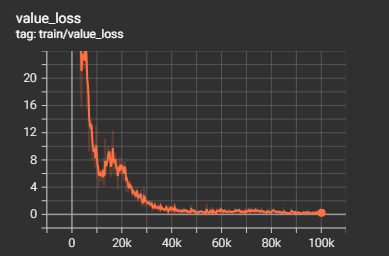

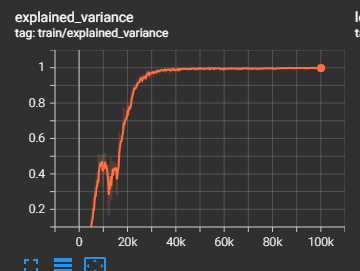